In [1]:
%pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
with open("names.txt",'r') as file:
    words = file.read().splitlines()
print(len(words),words[:5])

32033 ['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [4]:
# build the vocab of char and map to ints
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos = {i:ch for ch,i in stoi.items()}
vocab_size=len(itos)

In [5]:
block_size = 8 # context len to predic the next char
    
def build_dataset(words):
    # build the dataset
    X,Y = [],[] # inputs, labels
    for w in words:
    #     print(w)
        context = [0]*block_size #padded context for start
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:]+[ix] # crop & append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
random.seed(42)
random.shuffle(words)
n1,n2 = int(len(words)*0.8),int(len(words)*0.9)
Xtr,Ytr = build_dataset(words[:n1])     # 80%
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
# X,Y = Xtr,Ytr

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x),'-->',itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
# Train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momemtum=0.1):
        self.eps = eps
        self.momemtum = momemtum
        self.training = True
        # params (trained with backprop)
        self.gamma = torch.ones(dim) # y = BN(gamma) + beta
        self.beta = torch.zeros(dim)
        # buffer (trained with a running 'momemtum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calc the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim,keepdim=True) # batch mean
            xvar = x.var(dim,keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta # y = BN*gamma + beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momemtum) * self.running_mean + self.momemtum * xmean
                self.running_var = (1-self.momemtum) * self.running_var + self.momemtum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B,T//self.n,C*self.n)
        if x.shape[1]==1:
            x=x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get params of all layers
        return [p for l in self.layers for p in l.parameters()]
        

In [8]:
torch.manual_seed(42);

In [9]:
n_embd =24
n_hidden = 200

C = torch.randn((vocab_size,n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last_layer: make less confident
    model.layers[-1].weight *= 0.1
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # num of params in total

for p in parameters:
    p.requires_grad = True

176875


In [10]:
# training mode

max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in tqdm(range(max_steps)):
    
    # minibatch construct 
    ix = torch.randint(0,Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    x = model(Xb)
    loss = F.cross_entropy(x,Yb) # loss func
    
    # backward pass
    for p in parameters:
        p.grad = None # zero grad
    loss.backward()
    
    # update
    lr = 0.1 if i <max_steps/2 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track data
    if i%10000 == 0: #print once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
#     break

  0%|                           | 36/200000 [00:00<09:20, 356.53it/s]

      0/ 200000: 3.2983


  5%|█▏                      | 10062/200000 [00:33<09:29, 333.62it/s]

  10000/ 200000: 1.9029


 10%|██▍                     | 20072/200000 [00:57<07:34, 395.52it/s]

  20000/ 200000: 2.2528


 15%|███▌                    | 30079/200000 [01:21<06:32, 433.11it/s]

  30000/ 200000: 2.3363


 20%|████▊                   | 40046/200000 [01:43<06:02, 440.66it/s]

  40000/ 200000: 1.5219


 25%|██████                  | 50051/200000 [02:06<05:30, 453.34it/s]

  50000/ 200000: 2.1601


 30%|███████▏                | 60062/200000 [02:29<05:06, 456.66it/s]

  60000/ 200000: 2.0272


 35%|████████▍               | 70052/200000 [02:52<04:55, 440.28it/s]

  70000/ 200000: 2.0029


 40%|█████████▌              | 80066/200000 [03:15<04:30, 443.36it/s]

  80000/ 200000: 2.0345


 45%|██████████▊             | 90044/200000 [03:39<04:12, 436.33it/s]

  90000/ 200000: 1.8955


 50%|███████████▌           | 100053/200000 [04:04<03:41, 451.66it/s]

 100000/ 200000: 1.9339


 55%|████████████▋          | 110057/200000 [04:27<03:48, 393.55it/s]

 110000/ 200000: 1.4762


 60%|█████████████▊         | 120056/200000 [04:51<03:36, 369.20it/s]

 120000/ 200000: 1.8475


 65%|██████████████▉        | 130052/200000 [05:16<02:42, 429.61it/s]

 130000/ 200000: 1.9812


 70%|████████████████       | 140077/200000 [05:41<02:16, 438.93it/s]

 140000/ 200000: 1.9214


 75%|█████████████████▎     | 150077/200000 [06:04<01:54, 434.14it/s]

 150000/ 200000: 1.7126


 80%|██████████████████▍    | 160085/200000 [06:27<01:29, 444.01it/s]

 160000/ 200000: 2.0511


 85%|███████████████████▌   | 170059/200000 [06:50<01:13, 406.40it/s]

 170000/ 200000: 1.6301


 90%|████████████████████▋  | 180055/200000 [07:14<00:48, 412.13it/s]

 180000/ 200000: 1.7809


 95%|█████████████████████▊ | 190073/200000 [07:38<00:23, 429.62it/s]

 190000/ 200000: 1.6447


100%|███████████████████████| 200000/200000 [08:01<00:00, 415.57it/s]


In [11]:
for layer in model.layers:
    print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


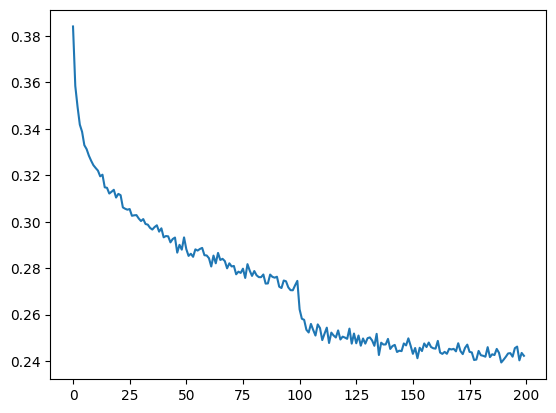

In [12]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [13]:
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad() # disables grad tracking 
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]
    loss = F.cross_entropy(model(x),y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7270246744155884
val 1.9899896383285522


In [29]:
# sample from the model
gen_words = []
wrds = set(words)
cnt = 0
for _ in range(200):
    out = []
    context = [0]*block_size # init ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    wrd = ''.join(itos[i] for i in out)
    if wrd[:-1] not in wrds:
        cnt += 1
        print(wrd[:-1])


jonnis
baxlin
mathar
clavienne
aswes
donate
margyna
desting
jazzlen
anrylan
kendrigo
xare
rahktog
haydri
ihkin
chipunokh
keonnie
olamrah
kelieyah
emprysyn
diton
ajayyia
blakon
yeon
cawner
zayoni
daviyah
abrianni
lynastone
ronis
gyette
vihaala
marqueen
darx
kaiveus
tamimra
markin
carolanna
farrie
tianny
arians
khyland
reylie
felio
kynx
meslayna
chancy
kenla
yoss
breezek
majo
akshi
suhayfa
kerjamea
lalayna
renaya
venoch
jarine
kayryn
tymaraj
heroni
araston
stevanna
starlitu
heian
nakaia
drajan
roseas
rozaleigh
zovan
braynna
sonabella
treann
mayvn
oziberto
benuhett
merra
ahrista
zalonna
treasinachie
arzo
fendlette
terusana
amitt
egamar
banyoluwa
niviana
zaraiya
levwando
vahave
tarom
selysa
adeson
yoniyah
vahaniah
meilanie
ariaman
deugran
jonater
ukham
laylan
amelan
